# Collecting Data (Tweets from NY)

# Data - PreProcessing

Because we don't have property of gender in tweet structure, we needed to use the NLTK well known names to build our train dataset.

In order to extract as much as possible the correct gender, we filter all the names which can be use for female and for male.

In [8]:
#import nltk
#nltk.download()

from nltk.corpus import names

def GetWellDefineGenderFromName(first_name):
    first_name = first_name.lower()
    first_name = first_name.title()
    matchMale = False
    matchFemale = False
    if first_name in names.words("male.txt"):
        matchMale = True
    if first_name in names.words("female.txt"):
        matchFemale = True
    if matchMale and matchFemale:
        return None
        
    if matchMale:        
        return 'male'
        
    if matchFemale:
        return 'female'        
        
    return None

## Fetch raw data from tweeter

In [ ]:
#!conda install -c conda-forge tweepy=3.5.0
#!conda install -c malev gender_detector=0.1.0

import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import requests
import json

#function to determine gender from first name
#estimate the gender at the level of confidence above 0.50        
#gender = GetGender(first_name, 0.50)
#print('Gender: %s' % gender)
def GetGender(name, probability):
    r = requests.get("https://api.genderize.io/?name=%s"% name)
    r_json = json.loads(r.content)
    
    if r_json['gender'] == 'null':
        return None
    
    if float(r_json['probability']) < probability:
        return None
    
    return r_json['gender']    

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

class StdOutListener(StreamListener):
    def on_data(self, data):            
        
        tweet = json.loads(data)
        
        if not tweet.get('user'):
            return True
        
        user = tweet['user']    
        
        if user['lang'] != 'en':
            return True
        
        if user['location'] is None:
            return True
        
        if 'New York' not in user['location'] and 'NY' not in user['location']:
            return True
        
        gender = GetWellDefineGenderFromName(user['name'].encode('utf-8').split()[0])
        
        if gender is None:
            return True
        
        # append the hourly tweet file
        with open('tweets.data', 'a+') as f:
            f.write(data)            
        
        return True
    
    def on_error(self, status):
        print('status: %s' % status)

streamListener = StdOutListener()
stream = Stream(auth, streamListener, timeout=30)
stream.filter(locations=[-74,40,-73,41], track=['The', 'I', 'she', 'and'])

## Data Cleaning - Define fucntions

### Decoding text to Ascii

Decoding data: Thisis the process of transforming information from complex symbols to simple and easier to understand characters. Text data may be subject to different forms of decoding like “Latin”, “UTF8” etc. Therefore, for better analysis, it is necessary to keep the complete data in standard encoding format. UTF-8 encoding is widely accepted and is recommended to use.

In [2]:
def UTFToAscii(string):
    return string.decode('ascii', 'ignore')

### Remove URLs, hashtags, @user_reference

In [3]:
import re
import urlparse

def RemoveNonWords(string):
    return re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", string)

def RemoveSymbols(string):
    new_string = ''
    for i in string.split():
        s, n, p, pa, q, f = urlparse.urlparse(i)
        if s and n:
            pass
        elif i[:1] == '@':
            new_string = new_string.strip() + ' ' + i[1:]
        elif i[:1] == '#':
            new_string = new_string.strip() + ' ' + i[1:]
        else:
            new_string = new_string.strip() + ' ' + i
    return new_string

### Handle Escaping Characters

In [4]:
import HTMLParser

def RemoveEscaping(string):
    html_parser = HTMLParser.HTMLParser()
    return html_parser.unescape(string)

### Convert to lowercase

In [5]:
def ToLowercase(string):
    return string.lower()

### Handle Apostrophe Lookup

In [6]:
import csv

def ReplaceApostrophe(string):
    appostophes_dict = None

    with open('appostophes.csv', mode='r') as infile:
        reader = csv.reader(infile)
        appostophes_dict = {rows[0]:rows[1] for rows in reader}
    
    words = string.split()
    reformed = [appostophes_dict[word] if word in appostophes_dict else word for word in words]
    string = " ".join(reformed)
    return string
    

### Clean RT

In [18]:
def RemoveRT(string):
    words = string.split()
    reformed = ['' if word in 'RT' else word for word in words]
    string = " ".join(reformed)
    return string

### Flat Lines

In [37]:
def FlatLines(string):
    lines = string.splitlines()
    string = " ".join(lines)
    return string

## Create dataframe from Json tweets file

In [40]:
import pandas as pd
import json

def IsEnglish(s):
    for i in s.split():
        if not i.isalpha():
            return False
    return True    

#read data from tweets.data

tweets_df = pd.DataFrame(columns=['id', 'text','name', 'gender'])
for line in open('tweets.data', 'r'):    
    tweet_data = json.loads(line)
    tweet_fullname = tweet_data['user']['name'].encode('utf-8')
    if IsEnglish(tweet_fullname) == False:
        continue

    if len(tweet_fullname.split()) < 2:
        continue

    tweet_text = tweet_data['text'].encode('utf-8')
    tweet_text = UTFToAscii(tweet_text)
    tweet_text = RemoveEscaping(tweet_text)
    tweet_text = FlatLines(tweet_text)
    tweet_text = RemoveNonWords(tweet_text)    
    tweet_text = RemoveRT(tweet_text)
    tweet_text = ToLowercase(tweet_text)
    tweet_text = ReplaceApostrophe(tweet_text)

    #filter all text that smaller then 2 words
    if len(tweet_text.split()) < 3:
        continue
    
    #filter all names with no legal capital letter
    if  len(re.findall(r'[A-Z]',tweet_fullname)) != len(tweet_fullname.split()):            
        continue
    
    gender = GetWellDefineGenderFromName(tweet_fullname.split()[0])
    
    if gender is None:
        continue

    tweets_df.loc[len(tweets_df)]=[tweet_data['id_str'], tweet_text, tweet_fullname, gender]


In [55]:
tweets_df.head(10)

,id,text,name,gender
0,875088051977977856,how to give your employees the recognition the...,Guy Santeramo,male
1,875088067471831043,that was lovely thank you for sharing i too lo...,Alexa Harrison,female
2,875088072786022400,sling could a team made entirely of players wh...,Jay Zampi,male
3,875088110736089089,my fan theory is that your fan theory has noth...,Susana Polo,female
4,875088135889334273,if you say so princess im sure hell love to se...,Brad Gibson,male
5,875088148770033665,when she asks you what you bring to the table,Solomon Grundy,male
6,875088173939818497,finally biting the bullet and reserving hotel ...,Meg Roy,female
7,875088203258109952,im speaking at digipub summit in new york this...,Adam Smith,male
8,875088215715217410,this couldnt be easier i just called my rep to...,Krystyna Hutchinson,female
9,875088231964041218,the gun contagion in america continues to thre...,Michael Corley,male


In [56]:
tweets_df.describe()

,id,text,name,gender
count,2482,2482,2482,2482
unique,2482,2395,2094,2
top,875432697602113537,i just want a country where affording health c...,Joel Finch,male
freq,1,8,11,1507


In [54]:
tweets_df.dtypes

id          object
text        object
name        object
gender    category
dtype: object

In [59]:
tweets_df.isnull().sum()

id        0
text      0
name      0
gender    0
dtype: int64

In [58]:
tweets_df['gender'] = tweets_df['gender'].astype('category')

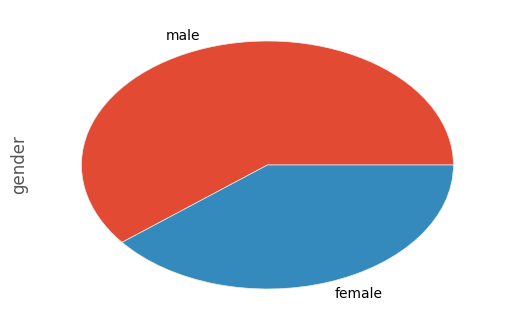

In [65]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

%matplotlib inline

plt.figure();

tweets_df.gender.value_counts().plot(kind='pie')